In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
import sklearn.metrics as sk
import scipy
import math
import seaborn as sns

In [2]:
nyc_2021 = np.load("nyc_2021.npy")
nyc_2022 = np.load("nyc_2022.npy")
nyc_2023 = np.load("nyc_2023.npy")

dc_2021 = np.load("dc_2021.npy")
dc_2022 = np.load("dc_2022.npy")
dc_2023 = np.load("dc_2023.npy")

philly_2021 = np.load("philly_2021.npy")
philly_2022 = np.load("philly_2022.npy")
philly_2023 = np.load("philly_2023.npy")

In [3]:
nyc_data = np.concatenate([nyc_2021, nyc_2022, nyc_2023])
dc_data = np.concatenate([dc_2021, dc_2022, dc_2023])
philly_data = np.concatenate([philly_2021, philly_2022, philly_2023])

In [4]:
nyc_data.shape

(1095, 8, 57, 59)

In [51]:
test_nyc = nyc_data[875:891]

In [5]:
test_nyc = nyc_data[:, :, 27, 32]

In [6]:
test_nyc.shape

(1095, 8)

In [7]:
new_test = []

for x in range(1095-8):
    new_test.append(test_nyc[x:x+8])

In [8]:
new_test = np.array(new_test)
new_test.shape

(1087, 8, 8)

In [9]:
test_features = new_test[:-1]
test_labels = new_test[1:]

In [10]:
np.save("time_series_features.npy", test_features)
np.save("time_series_labels.npy", test_labels)

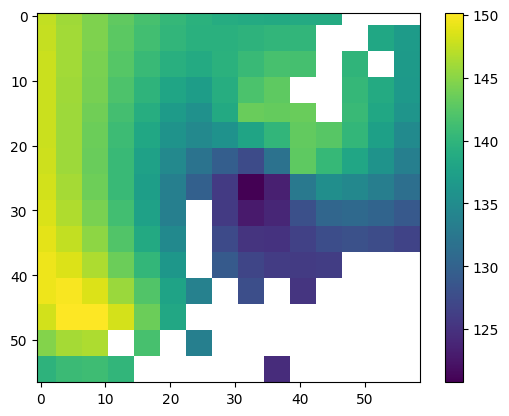

In [46]:
plt.imshow(nyc_data[887, -1])
plt.colorbar()
plt.show()

In [4]:
def plot_time_series(nyc_pm25, city_name):

    nyc_pm25 = nyc_pm25.reshape(nyc_pm25.shape[0], nyc_pm25.shape[1] * nyc_pm25.shape[2])

    avg = []
    for day in nyc_pm25:
        masked_data = np.ma.masked_array(day, np.isnan(day))
        avg.append(np.average(masked_data))

    plt.figure(figsize=(20,5))
    # Generate a range of dates
    date_range = pd.date_range(start="2021-01-01", end="2023-12-31", freq='D')

    # Convert the date range to a string
    date_strings = date_range.strftime('%Y-%m-%d')

    plt.plot(date_strings, avg)

    # Set the interval for the x-axis labels
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=24))  # Display up to 12 labels


    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    plt.title(f'Time Series of Average PM2.5 Concentration in {city_name}')
    plt.xlabel("Date")
    plt.ylabel("Average PM2.5 Concentration (µg/m3)")
    plt.show

In [21]:
def plot_distribution(nyc_pm25, city_name):

    data = nyc_pm25.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=70, kde=True, color='blue')
    #plt.xlim([40, 150]) 
    plt.title(f'Distribution of PM2.5 after {city_name}')
    plt.xlabel('PM2.5 Concentration (µg/m3)')
    plt.ylabel('Frequency')
    plt.show()

In [5]:
def preprocessing(city_data):
    days = city_data.shape[0]
    lat = city_data.shape[2]
    lon = city_data.shape[3]
    
    features = city_data[:-8, :, :, :]
    labels = city_data[8:, :, :, :]
    
    #print(features.shape)
    
    features_flattened = []
    labels_flattened = []
    
    for d in range(len(features)-7):
        for x in range(lat):
            for y in range(lon):
                features_flattened.append(features[d:d+8, :, x, y])
                labels_flattened.append(labels[d:d+8, :, x, y])
                
    #print(np.array(features_flattened).shape)
    
    features_full = []
    labels_full = []
    
    for i in range(len(features_flattened)):
        if not np.isnan(features_flattened[i]).any():
            features_full.append(features_flattened[i])
            labels_full.append(labels_flattened[i])
            
    return np.array(features_full), np.array(labels_full)

In [68]:
features = []
labels = []
for x in range(0, 1095-15):
    feat, labe = preprocessing(philly_data[x:x+16])
    features.append(feat)
    labels.append(labe)

In [69]:
features = np.array(features)
labels = np.array(labels)

In [70]:
features.shape

(1080, 1190, 8, 8)

In [71]:
np.save("philly_time_features.npy", features)
np.save("philly_time_labels.npy", labels)

In [6]:
nyc_features, nyc_labels = preprocessing(nyc_data)
philly_features, philly_labels = preprocessing(philly_data)
dc_features, dc_labels = preprocessing(dc_data)

In [10]:
np.random.seed(42)
# Generate random indices
random_indices = np.random.choice(len(dc_features), size=34980, replace=False)

np.save("dc_test_features.npy", dc_features[random_indices])
np.save("dc_test_labels.npy", dc_labels[random_indices])

In [47]:
nyc_features.shape

(2284200, 8, 8)

In [63]:
test_features, test_labels = preprocessing(test_nyc)

(8, 10, 57, 59)
(3363, 8, 10)


In [64]:
np.save("test_features.npy", test_features)
np.save("test_labels.npy", test_labels)

In [8]:
all_features = np.concatenate([nyc_features, philly_features, dc_features])
all_labels = np.concatenate([nyc_labels, philly_labels, dc_labels])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

In [51]:
np.random.seed(42)
# Generate random indices
random_indices = np.random.choice(len(X_test), size=100_000, replace=False)

np.save("base_features.npy", X_test[random_indices])
np.save("base_labels.npy", y_test[random_indices])

In [34]:
_, __, high_features, high_labels = sort_high_low(X_test, y_test)

In [35]:
high_features.shape

(110544, 8, 8)

In [37]:
np.random.seed(42)
# Generate random indices
random_indices = np.random.choice(len(high_features), size=4317 , replace=False)

In [38]:
np.save('high_12_features.npy', high_features[random_indices])
np.save("high_12_labels.npy", high_labels[random_indices])

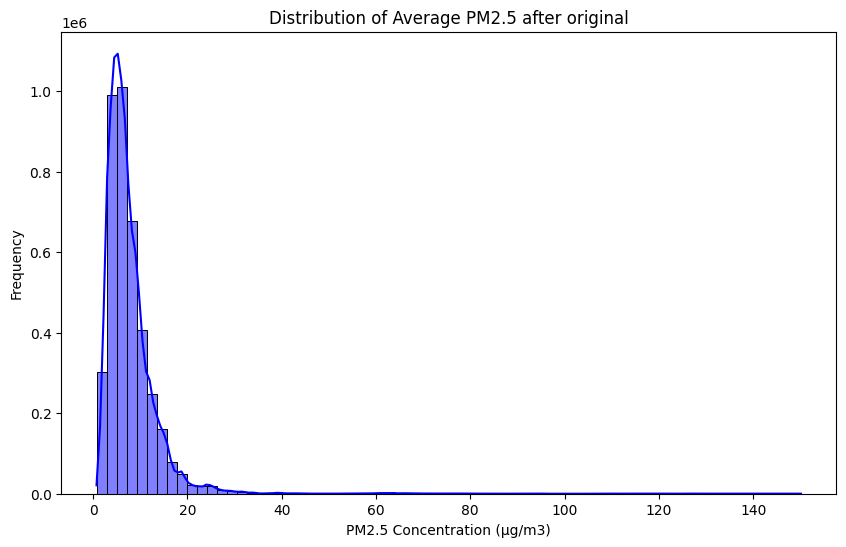

In [15]:
plot_distribution(all_features[:, 0, 7], "original")

In [16]:
arr = all_features[:, 0, 7]
print("50th percentile of arr : ",
      np.percentile(arr, 50))
print("90th percentile of arr : ",
      np.percentile(arr, 90))
print("95th percentile of arr : ",
      np.percentile(arr, 95))

50th percentile of arr :  6.471701622009277
90th percentile of arr :  13.430424690246582
95th percentile of arr :  16.227598190307617


In [25]:
def sort_high_low(features, labels):
    low_features = []
    low_labels = []
    
    high_features = []
    high_labels = []
    
    for i in range(len(features)):
        threshold = 12.1

    # Check if any value in the array is above the threshold
        features_above_threshold = np.mean(features[i, :, -1]) >= threshold
        labels_above_threshold = labels[i, 0, -1] >= threshold
        if labels_above_threshold:
            high_features.append(features[i])
            high_labels.append(labels[i])
        else:
            low_features.append(features[i])
            low_labels.append(labels[i])
    
    return np.array(low_features), np.array(low_labels), np.array(high_features), np.array(high_labels)

In [40]:
low_features, low_labels, high_features, high_labels = sort_high_low(X_train, y_train)
low = len(low_features)
high = len(high_features)
print(f'low values: {len(low_features)}')
print(f'high values: {len(high_features)}')
print(low + high)
print(high/low)

low values: 2777985
high values: 443007
3220992
0.15947062349148752


no augmentation, just sampling

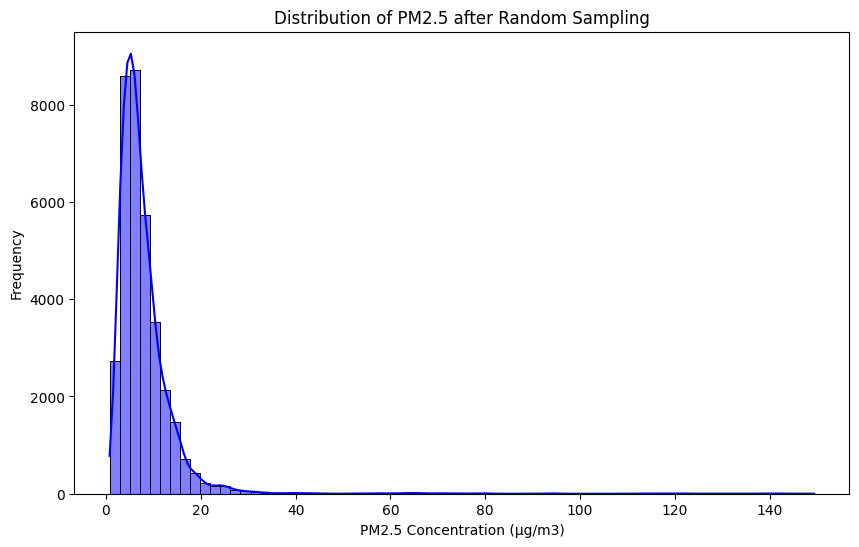

In [23]:
np.random.seed(42)
#np.random.seed(19)

indices = np.random.choice(len(X_train), size=34980, replace=False)

features_sample = X_train[indices]
labels_sample = y_train[indices]

plot_distribution(labels_sample[:, 0, 7], "Random Sampling")

In [61]:
np.save("features.npy", features_sample)
np.save("labels.npy", labels_sample)

random undersampling

In [22]:
np.random.seed(42)
# Generate random indices
random_indices = np.random.choice(len(low_features), size=high, replace=False)

# Get the sample using the random indices
low_sample_features = low_features[random_indices]
low_sample_labels = low_labels[random_indices]

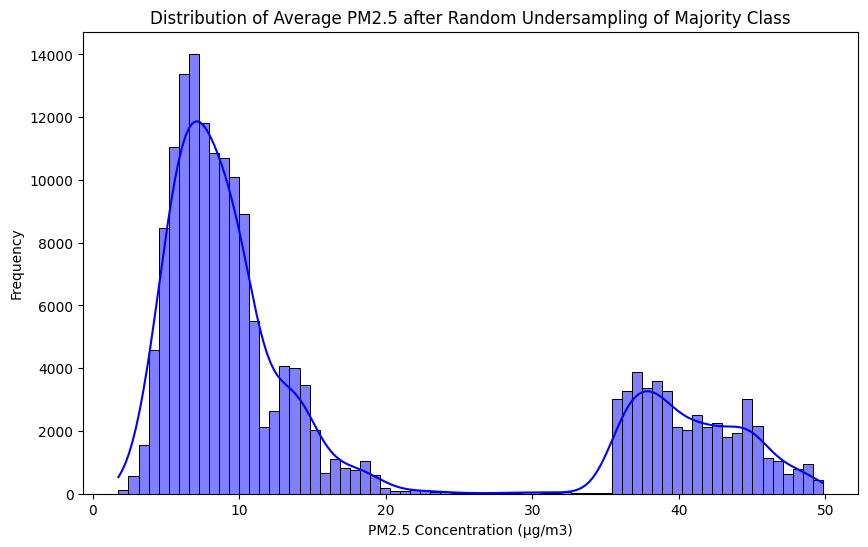

In [23]:
features_random = np.concatenate([high_features, low_sample_features])
labels_random = np.concatenate([high_features, low_sample_labels])
sort_features = np.concatenate([np.mean(features_random[:, :, -1], axis = 1), np.mean(labels_random[:, :, -1], axis = 1)])
plot_distribution(sort_features, "Random Undersampling of Majority Class")

cluster based undersampling

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter

# Step 3: Separate the majority and minority classes
X_majority = low_features[:, :, -1]
y_majority = low_labels[:, :, -1]
X_minority = high_features[:, :, -1]
y_minority = high_labels[:, :, -1]

# Step 4: Perform KMeans clustering on the majority class with fewer clusters
n_clusters = 10  # Reduced number of clusters
kmeans = KMeans(n_clusters=n_clusters, max_iter = 100, random_state=42)
kmeans.fit(X_majority)

# Step 5: Assign samples to clusters
cluster_labels = kmeans.predict(X_majority)

total = len(X_minority)

# Step 6: Undersample from each cluster
X_majority_undersampled = []
y_majority_undersampled = []
samples_per_cluster = total // n_clusters

for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if cluster == n_clusters-1:
        samples_per_cluster += 4
    selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)
    X_majority_undersampled.extend(low_features[selected_indices])
    y_majority_undersampled.extend(low_labels[selected_indices])

X_majority_undersampled = np.array(X_majority_undersampled)
y_majority_undersampled = np.array(y_majority_undersampled)

# Step 7: Combine the undersampled majority class with the minority class
X_resampled = np.vstack((X_majority_undersampled, high_features))
y_resampled = np.hstack((y_majority_undersampled, high_labels))

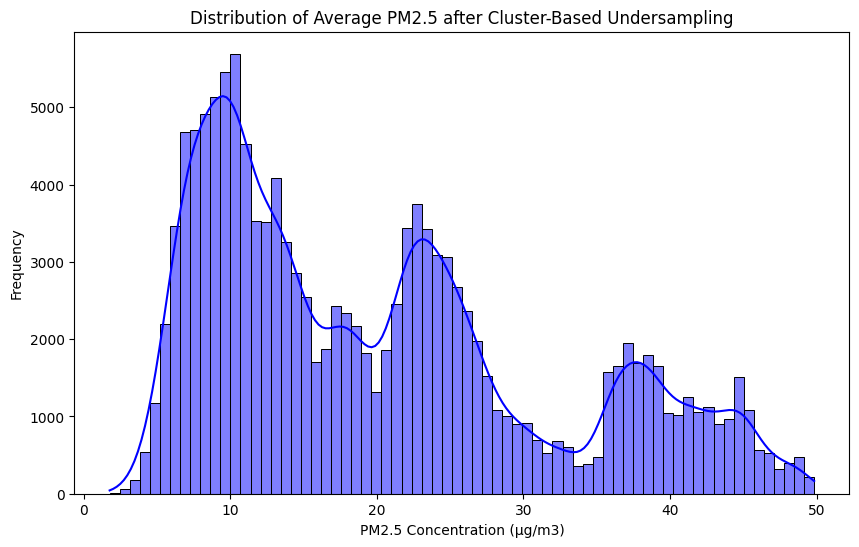

In [23]:
sort_features = np.concatenate([np.mean(X_resampled[:, :, -1], axis = 1), np.mean(y_resampled[:, :, -1], axis = 1)])
plot_distribution(sort_features, "Cluster-Based Undersampling")

tomek links

In [26]:
np.save("random_sampling_features.npy", features_sample)
np.save("random_sampling_labels.npy", labels_sample)

np.save("under_sampling_features.npy", features_random)
np.save("under_sampling_labels.npy", labels_random)

np.save("cluster_sampling_features.npy", X_resampled)
np.save("cluster_sampling_labels.npy", y_resampled)


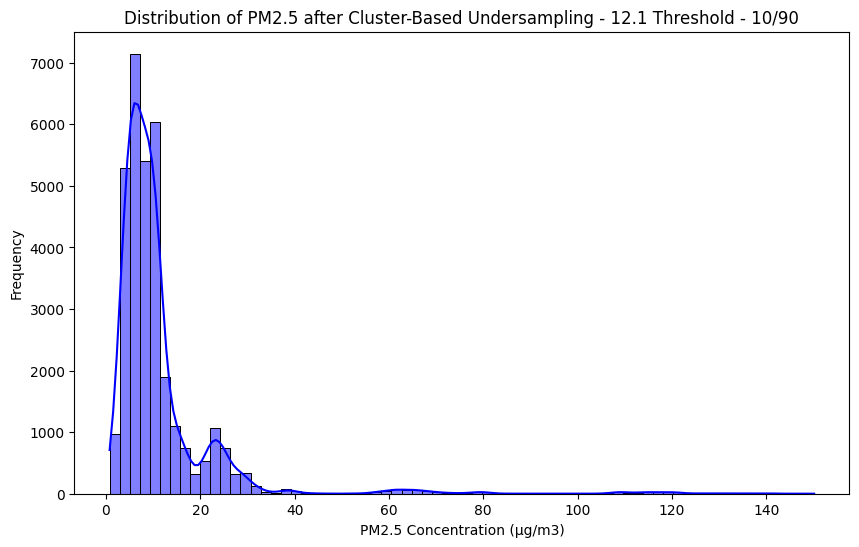

(32892, 8, 8)


In [46]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter

ratio = [0.1, 0.2, 0.3, 0.4, 0.5]
name = ["10/90", "20/80", "30/70", "40/60", "50/50"]
#np.random.seed(19)
np.random.seed(42)
for i in range(1):
    num_high = int(ratio[i] * 34980)
    num_low = int(34980 - num_high)
    
    # Step 3: Separate the majority and minority classes
    X_majority = low_features[:, :, -1]
    y_majority = low_labels[:, :, -1]
    X_minority = high_features[:, :, -1]
    y_minority = high_labels[:, :, -1]

    # Step 4: Perform KMeans clustering on the majority class with fewer clusters
    n_clusters = 10  # Reduced number of clusters
    kmeans = KMeans(n_clusters=n_clusters, max_iter = 100, random_state=42)
    kmeans.fit(X_majority)

    # Step 5: Assign samples to clusters
    cluster_labels = kmeans.predict(X_majority)

    total = num_low

    # Step 6: Undersample from each cluster
    X_majority_undersampled = []
    y_majority_undersampled = []
    samples_per_cluster = total // n_clusters
    count = 0

    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if cluster == n_clusters-1:
            samples_per_cluster = total - count
        selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)
        X_majority_undersampled.extend(low_features[selected_indices])
        y_majority_undersampled.extend(low_labels[selected_indices])
        count += len(selected_indices)

    X_majority_undersampled = np.array(X_majority_undersampled)
    y_majority_undersampled = np.array(y_majority_undersampled)

    #######################################################################################################################################################
    #######################################################################################################################################################

    n_clusters = 10  # Reduced number of clusters
    kmeans = KMeans(n_clusters=n_clusters, max_iter = 100, random_state=42)
    kmeans.fit(X_minority)

    # Step 5: Assign samples to clusters
    cluster_labels = kmeans.predict(X_minority)

    total = num_high

    # Step 6: Undersample from each cluster
    X_minority_undersampled = []
    y_minority_undersampled = []
    samples_per_cluster = total // n_clusters
    count = 0

    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if cluster == n_clusters-1:
            samples_per_cluster = total - count
        selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)
        X_minority_undersampled.extend(high_features[selected_indices])
        y_minority_undersampled.extend(high_labels[selected_indices])
        count += len(selected_indices)

    X_minority_undersampled = np.array(X_minority_undersampled)
    y_minority_undersampled = np.array(y_minority_undersampled)

    # Step 7: Combine the undersampled majority class with the minority class
    X_resampled = np.concatenate((X_majority_undersampled, X_minority_undersampled))
    y_resampled = np.concatenate((y_majority_undersampled, y_minority_undersampled))


    plot_distribution(y_resampled[:, 0, 7], "Cluster-Based Undersampling - 12.1 Threshold - " + name[i])

    print(X_resampled.shape)

    #np.save("features_12_" + name[i][:2] + ".npy", X_resampled)
    #np.save("labels_12_" + name[i][:2] + ".npy", y_resampled)

